In [9]:
conda install -c pytorch torchvision cudatoolkit=10.1 pytorch

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - cudatoolkit=10.1

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.5
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/Users/omarmedhat/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
# image enhancing algorithm before applying any images to our model
# Histogram equalization

import numpy as np

def histogram_equalization(image):
    
    hist, bins = calculate_histogram(image)
    
    cdf = calculate_cdf(hist)
    
    equalized_image = equalize_image(image, cdf)
    
    plt.imshow(equalized_image, cmap='gray')  
    plt.axis('off')
    plt.show()


def calculate_histogram(image):
    hist = np.zeros(256, dtype=np.int32)
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            hist[pixel_value] += 1
    return hist, np.arange(256)

def calculate_cdf(hist):
    cdf = np.cumsum(hist)
    cdf_normalized = cdf / float(cdf[-1])  # Normalize to [0, 1]
    return cdf_normalized

def equalize_image(image, cdf):
    equalized_image = np.zeros_like(image)
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            equalized_pixel_value = int(round(cdf[pixel_value] * 255))
            equalized_image[i, j] = equalized_pixel_value
    return equalized_image


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def histogram_equalization(image):
    equalized_channels = [equalize_channel(channel) for channel in np.rollaxis(image, axis=-1)]
    equalized_image = np.stack(equalized_channels, axis=-1)

    return equalized_image

def equalize_channel(channel):
    hist, bins = calculate_histogram(channel)
    cdf = calculate_cdf(hist)
    equalized_channel = equalize_image(channel, cdf)
    return equalized_channel

def calculate_histogram(channel):
    hist = np.zeros(256, dtype=np.int32)
    height, width = channel.shape
    for i in range(height):
        for j in range(width):
            pixel_value = channel[i, j]
            hist[pixel_value] += 1
    return hist, np.arange(256)

def calculate_cdf(hist):
    cdf = np.cumsum(hist)
    cdf_normalized = cdf / float(cdf[-1])  # Normalize to [0, 1]
    return cdf_normalized

def equalize_image(channel, cdf):
    equalized_channel = np.zeros_like(channel)
    height, width = channel.shape
    for i in range(height):
        for j in range(width):
            pixel_value = channel[i, j]
            equalized_pixel_value = int(round(cdf[pixel_value] * 255))
            equalized_channel[i, j] = equalized_pixel_value
    return equalized_channel




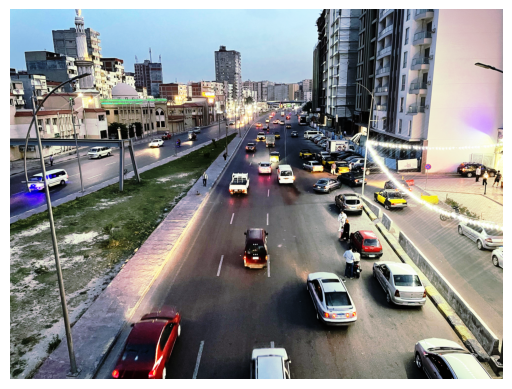

In [7]:
import cv2
image = cv2.imread("smoha.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
myimg = histogram_equalization(image_rgb)
plt.imshow(myimg)  
plt.axis('off')
plt.show()

In [5]:
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

def detect_image(img):
    # scale and pad image
    ratio = min(img_size / img.size[0], img_size / img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([
        transforms.Resize((imh, imw)),
        transforms.Pad((max(int((imh - imw) / 2), 0), max(int((imw - imh) / 2), 0), max(int((imh - imw) / 2), 0),
                        max(int((imw - imh) / 2), 0)),
                       (128, 128, 128)),
        transforms.ToTensor(),
    ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor)
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 90, conf_thres, nms_thres)
    return detections[0]


Inference Time: 0:09:21.890547


<Figure size 640x480 with 0 Axes>

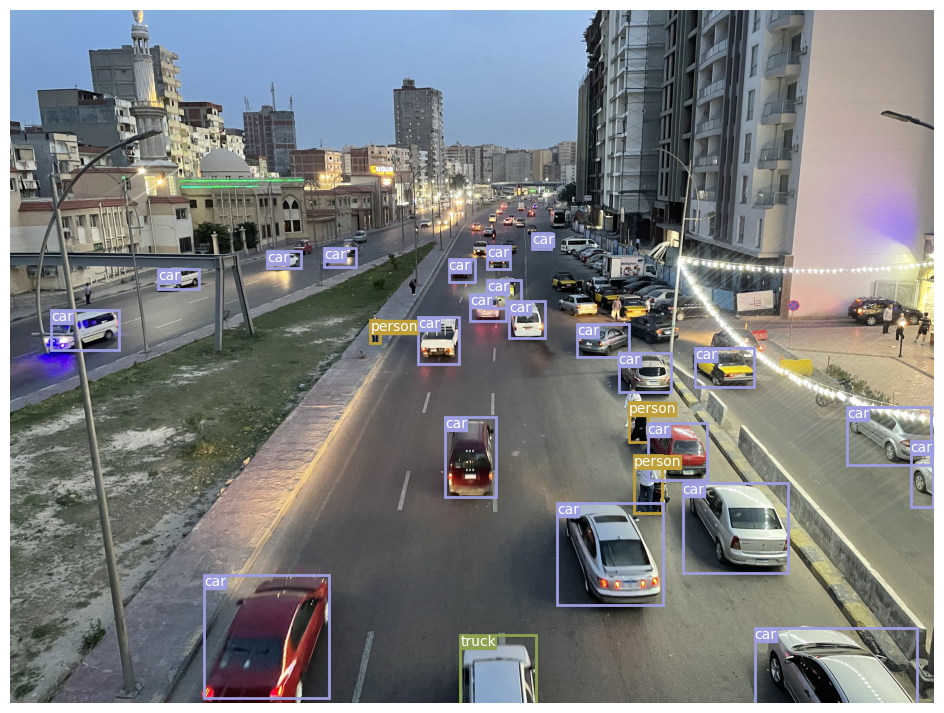

In [57]:
# load image and get detections

#img_path = "smoha.jpg"
#prev_time = time.time()
#img = Image.open(img_path)

from PIL import Image
pil_image = Image.fromarray(myimg)

detections = detect_image(pil_image)

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show()

Inference Time: 0:00:00.560346


<Figure size 640x480 with 0 Axes>

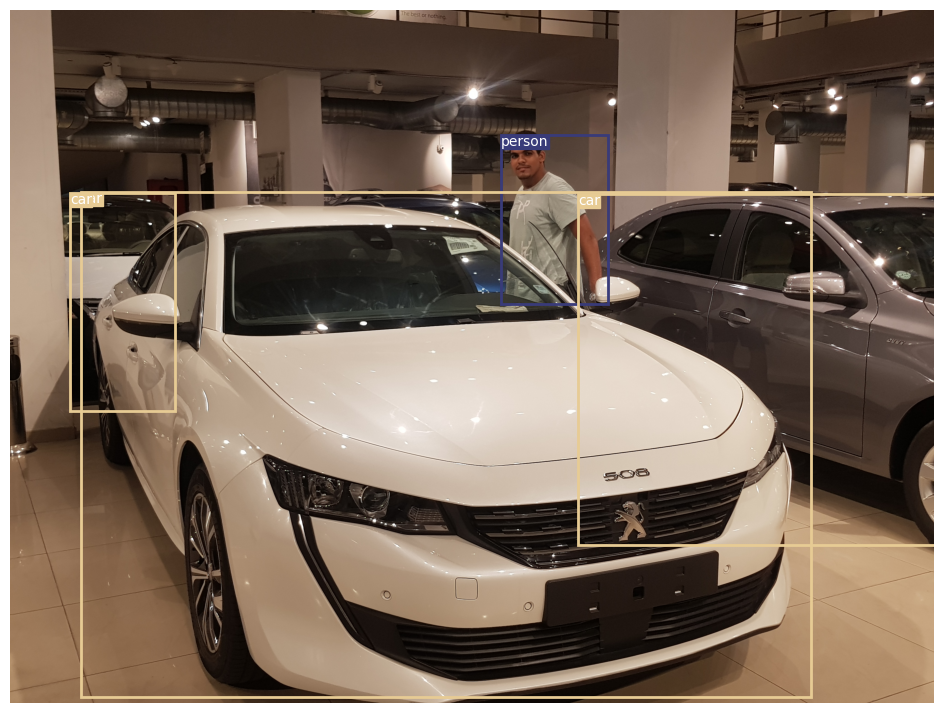

In [12]:
# load image and get detections

img_path = "ashrf.jpg"
prev_time = time.time()
img = Image.open(img_path)

#from PIL import Image
#pil_image = Image.fromarray(myimg)

detections = detect_image(img)

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show()

Inference Time: 0:00:00.888322


<Figure size 640x480 with 0 Axes>

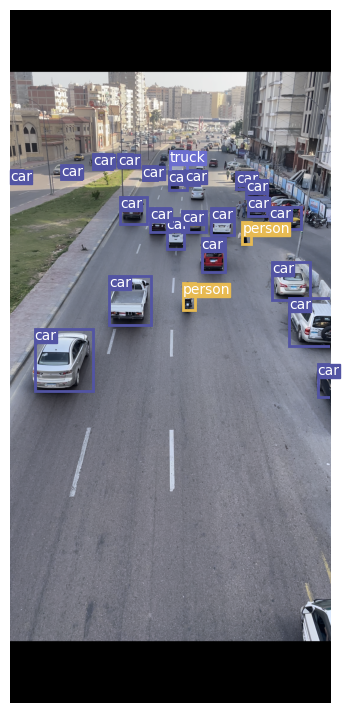

In [8]:
# load image and get detections

img_path = "IMG_7468.PNG"
prev_time = time.time()
img = Image.open(img_path)

#from PIL import Image
#pil_image = Image.fromarray(myimg)

detections = detect_image(img)

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show()